In [1]:
import os
import re
import numpy as np
import pandas as pd
import json
from pathlib import Path
from collections import defaultdict

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

import xgboost as xgb

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def load_json(filepath: str):
    with open(filepath) as file:
        data = json.load(file)
    return data

In [3]:
DATA_DIR = os.path.join(
    os.path.dirname(os.path.dirname(os.getcwd())), "data/"
)

PERIODIC_TABLE_PATH = os.path.join(
    os.path.dirname(os.getcwd()), "data_preprocessing/periodic_table_info.json",
)
PERIODIC_TABLE_INFO = load_json(PERIODIC_TABLE_PATH)

# Loading Data

In [4]:
def parse_structure_files(data_path, encoding):
    structure_files = {}
    p = Path(data_path)
    for struct_dir in p.iterdir():
        if not struct_dir.is_dir():
            continue
        for file in struct_dir.glob(f"*{encoding}*.csv"):
            structure_name = os.path.basename(struct_dir)

            # Parsing the structure name to get the elements and their number
            elts = re.findall("[A-Z][^A-Z]*", structure_name)
            elements_nbrs = defaultdict(int)
            for elt in elts:
                atom_num = re.findall("\d+|\D+", elt)
                if len(atom_num) == 1:
                    elements_nbrs[elt] += 1
                else:
                    elements_nbrs[elt[0]] += int(elt[1])

            # Skip Lantanides
            isLant = False
            for elt in elements_nbrs.keys():
                if PERIODIC_TABLE_INFO[elt]["PTC"] == "Lant":
                    isLant = True
            if not isLant:
                structure_files[structure_name] = file
            
    return structure_files

In [5]:
encoding = "column_mass"
structure_files = parse_structure_files(DATA_DIR, encoding)

In [6]:
df = pd.concat([pd.read_csv(filepath, index_col=0).assign(structure=struct_name) for struct_name, filepath in structure_files.items()], ignore_index=True)
df = df[["structure"] + df.columns.tolist()[:-1]]

In [7]:
cols_raw = list(df.columns)
cols_trash = ["structure", 'converged', 'accuracy', "n_iterations", "time", "fermi", "total_energy"]
cols_independent = ['delta_E']
cols_drop = cols_trash + cols_independent

cols_dependent = cols_raw.copy()
for element in cols_drop:
    cols_dependent.remove(element)

In [8]:
X_raw = df[cols_dependent][df["converged"]]
y_raw = np.abs(df[cols_independent][df["converged"]]).squeeze()

In [9]:
X_raw.describe()

,ecutrho,k_density,ecutwfc,PTC1,PTC2,PTC3,PTC4,PTC5,PTC6,PTC7,...,PTC9,PTC10,PTC11,PTC12,PTC13,PTC14,PTC15,PTC16,PTC17,PTC18
count,35083.000000,35083.000000,35083.000000,35083.000000,35083.000000,35083.000000,35083.000000,35083.000000,35083.000000,35083.000000,...,35083.000000,35083.000000,35083.000000,35083.000000,35083.000000,35083.000000,35083.000000,35083.000000,35083.000000,35083.0
mean,245.167745,5.841177,57.987059,0.052080,0.081474,0.029464,0.027170,0.053838,0.025416,0.035294,...,0.085387,0.070344,0.043066,0.036402,0.060445,0.070784,0.100005,0.065969,0.039442,0.0
std,89.310346,2.841955,23.982959,0.189782,0.234789,0.127134,0.123590,0.190910,0.119290,0.156705,...,0.237213,0.219887,0.169630,0.153505,0.188252,0.189871,0.228285,0.167038,0.160343,0.0
min,100.000000,2.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,180.000000,4.000000,35.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,260.000000,6.000000,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,340.000000,8.000000,80.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,380.000000,10.000000,100.000000,1.000000,1.000000,0.741626,0.841555,1.000000,0.783026,0.890822,...,1.000000,1.000000,1.000000,0.803422,0.967155,1.000000,0.918451,0.637235,0.833172,0.0


# Train-Test-Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y_raw,
    test_size=0.2,
    random_state=42
)

# Model definitions

### Linear Model with feature augmentation

In [11]:
# functions such that f(x) != 0 and f(+inf) = 0
functions_set_1 = [
    lambda x: np.exp(-x),
    lambda x: 1 / (1+x),
    lambda x: 1 / (1+x)**2,
    lambda x: np.cos(x) * np.exp(-x),
]

# functions such that f(x) = 0 and f(+inf) = 0
functions_set_2 = [
    lambda x: x*np.exp(-x),
    lambda x: x / (1+x)**2,
    lambda x: x / (1+x)**3,
    lambda x: np.sin(x) * np.exp(-x),
]

linear_augmented_model = Pipeline([
    ('scaler_init', StandardScaler()),
    ('features', FeatureUnion(
    [
        (f"fun_{j}", FunctionTransformer(lambda X : f(X[:,:3]))) for j, f in enumerate(functions_set_1 + functions_set_2)
    ] + [
        (f"fun_{j}_col_{col}_1", FunctionTransformer(lambda X : f(X[:,:3] * X[:,i][:, None]))) for j, f in enumerate(functions_set_1) for i, col in enumerate(["ecutrho", "kpoints", "ecutwfc"])
    ] + [
        (f"fun_{j}_col_{col}_2", FunctionTransformer(lambda X : f(X[:,3:] * X[:,i][:, None]))) for j, f in enumerate(functions_set_2) for i, col in enumerate(["ecutrho", "kpoints", "ecutwfc"])
    ])),
    ('scaler_final', StandardScaler()),
    ('regressor', LinearRegression()),
])

### Random forest

In [12]:
rf_model = RandomForestRegressor(random_state=0)

### Gradient Boosting

In [13]:
gb_model = GradientBoostingRegressor(n_estimators=5000, learning_rate=0.05, random_state=0)

### XGBoost

In [14]:
xgb_model = xgb.XGBRegressor(n_estimators=5000, learning_rate=0.05, random_state=0, tree_method="gpu_hist")

### Packing them together to reduce code size

In [15]:
models = {
    "Augmented Linear Regression": linear_augmented_model,
    "Random Forest": rf_model,
    # "Gradient Boosting": gb_model,
    "XGBoost": xgb_model,
}

# Model training

In [16]:
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    print("Done!\n")

Training Augmented Linear Regression...
Done!

Training Random Forest...
Done!

Training XGBoost...
Done!



# Model evaluation

In [17]:
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    mse_test = mean_squared_error(y_test, y_pred_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    print(f"MSE:\ttrain:{mse_train:.4E}\ttest:{mse_test:.4E}")

    mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
    mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
    print(f"MAPE:\ttrain:{mape_train:.4E}\ttest:{mape_test:.4E}")

    print("Done!\n")

Evaluating Augmented Linear Regression...
MSE:	train:3.1452E-02	test:3.1034E-02
MAPE:	train:1.2553E+11	test:9.2791E+10
Done!

Evaluating Random Forest...
MSE:	train:2.8811E-06	test:1.3497E-05
MAPE:	train:2.9771E+08	test:5.2046E+08
Done!

Evaluating XGBoost...
MSE:	train:7.0425E-06	test:1.2122E-05
MAPE:	train:4.5000E+09	test:5.3568E+09
Done!



# Visualization

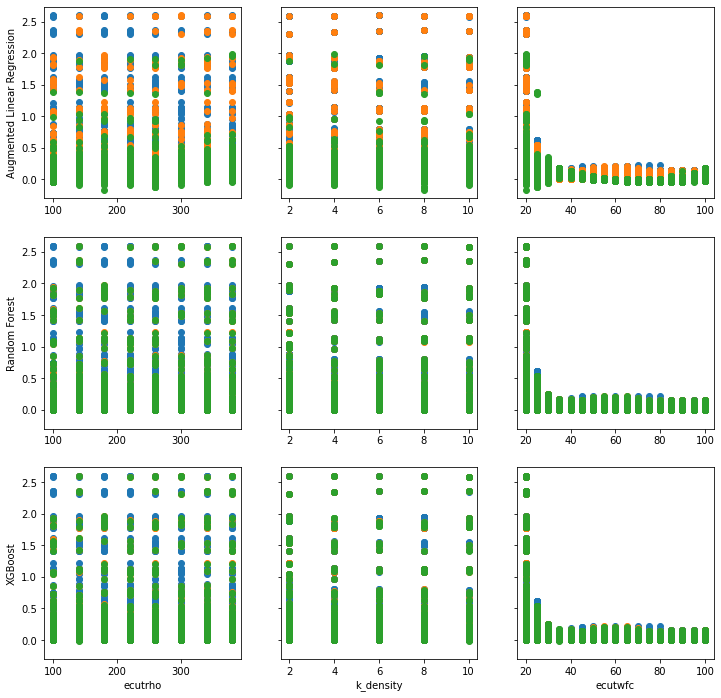

In [18]:
n_models = len(models)
fig, ax = plt.subplots(n_models,3,figsize=(12,4*n_models), sharey=True, squeeze=False)
for j, (name, model) in enumerate(models.items()):
    for i, col in enumerate(X_train.columns[:3]):
        ax[j,i].scatter(X_train[col], y_train)
        ax[j,i].scatter(X_test[col], y_test)
        ax[j,i].scatter(X_test[col], model.predict(X_test))
    ax[j,0].set_ylabel(name)
ax[-1,0].set_xlabel("ecutrho")
ax[-1,1].set_xlabel('k_density')
ax[-1,2].set_xlabel('ecutwfc')
PLOTPATH = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "plots/delta_E_regression/toy_comparison.png")
plt.savefig(PLOTPATH)

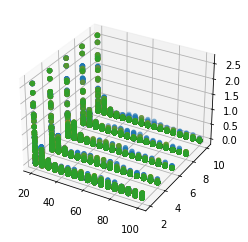

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train['ecutwfc'], X_train['k_density'], y_train)
ax.scatter(X_test['ecutwfc'], X_test['k_density'], y_test)
ax.scatter(X_test['ecutwfc'], X_test['k_density'], rf_model.predict(X_test))

## Predict $\log(\Delta E)$ instead of $∆E$

In [20]:
def log_transform(y, miny, eps=10E-15):
    return np.log(y - miny + eps)

def inv_log_transform(logy, miny, eps=10E-15):
    return np.exp(logy) + miny - eps

miny = float(np.min(y_raw))
maxy = float(np.max(y_raw))

y_raw_s = np.array(y_raw.squeeze())
miny2 = np.sort(list(set(list(y_raw_s))))[1]
eps = (miny2 - miny)/10

    

logy_raw = log_transform(y_raw, miny, eps)
X_train, X_test, logy_train, logy_test = train_test_split(
    X_raw, logy_raw,
    test_size=0.2,
    random_state=42
)

In [21]:
linear_log_augmented_model = Pipeline([
    ('scaler_init', StandardScaler()),
    ('features', PolynomialFeatures(degree=2)),
    ('scaler_final', StandardScaler()),
    ('regressor', LinearRegression()),
])

In [22]:
rf_log_model = RandomForestRegressor()

In [23]:
gb_log_model = GradientBoostingRegressor(n_estimators=5000, learning_rate=0.05, random_state=0)

In [24]:
xgb_log_model = xgb.XGBRegressor(n_estimators=5000, learning_rate=0.05, random_state=0, tree_method="gpu_hist")

In [25]:
models_log = {
    "Augmented Linear Regression - Log": linear_log_augmented_model,
    "Random Forest - Log": rf_log_model,
    # "Gradient Boosting - Log": gb_log_model,
    "XGBoost - Log": xgb_log_model,
}

In [26]:
for model_name, model in models_log.items():
    print(f"Training {model_name}...")
    model.fit(X_train, logy_train)
    print("Done!\n")

Training Augmented Linear Regression - Log...
Done!

Training Random Forest - Log...
Done!

Training XGBoost - Log...
Done!



In [27]:
for model_name, model in models_log.items():
    print(f"Evaluating {model_name}...")

    logy_pred_train = model.predict(X_train)
    y_pred_train = inv_log_transform(logy_pred_train.squeeze(), miny, eps)
    logy_pred_test = model.predict(X_test)
    y_pred_test = inv_log_transform(logy_pred_test.squeeze(), miny, eps)
    
    y_train = inv_log_transform(logy_train.squeeze(), miny, eps)
    y_test = inv_log_transform(logy_test.squeeze(), miny, eps)

    mse_test = mean_squared_error(logy_test, logy_pred_test)
    mse_train = mean_squared_error(logy_train, logy_pred_train)
    print(f"MSE:\ttrain:{mse_train:.4E}\ttest:{mse_test:.4E}")
    
    mse_test = mean_squared_error(y_test, y_pred_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    print(f"MSE:\ttrain:{mse_train:.4E}\ttest:{mse_test:.4E}")

    mape_test = mean_absolute_percentage_error(logy_test, logy_pred_test)
    mape_train = mean_absolute_percentage_error(logy_train, logy_pred_train)
    print(f"MAPE:\ttrain:{mape_train:.4E}\ttest:{mape_test:.4E}")

    print("Done!\n")

Evaluating Augmented Linear Regression - Log...
MSE:	train:2.5611E+00	test:2.5272E+00
MSE:	train:3.3584E-02	test:3.3115E-02
MAPE:	train:3.8672E-01	test:4.3667E-01
Done!

Evaluating Random Forest - Log...
MSE:	train:5.1618E-02	test:2.0401E-01
MSE:	train:1.5120E-05	test:3.7363E-05
MAPE:	train:8.7412E-03	test:1.8359E-02
Done!

Evaluating XGBoost - Log...
MSE:	train:4.7537E-02	test:2.1186E-01
MSE:	train:5.0626E-05	test:1.7085E-04
MAPE:	train:1.7238E-02	test:2.9520E-02
Done!



Text(0.5, 0, 'ecutwfc')

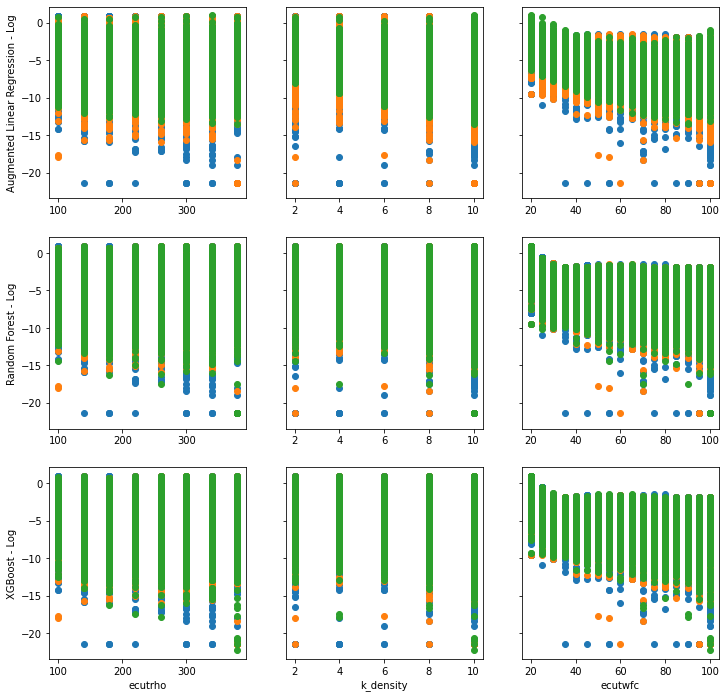

In [44]:
n_models = len(models_log)
fig, ax = plt.subplots(n_models,3,figsize=(12,4*n_models), sharey=True, squeeze=False)
for j, (name, model) in enumerate(models_log.items()):
    for i, col in enumerate(X_train.columns[:3]):
        ax[j,i].scatter(X_train[col], logy_train)
        ax[j,i].scatter(X_test[col], logy_test)
        ax[j,i].scatter(X_test[col], model.predict(X_test))
    ax[j,0].set_ylabel(name)
ax[-1,0].set_xlabel("ecutrho")
ax[-1,1].set_xlabel('k_density')
ax[-1,2].set_xlabel('ecutwfc')

# Find best parameters for a given error

In [29]:
from scipy.optimize import NonlinearConstraint, LinearConstraint, minimize, shgo, differential_evolution

In [30]:
def sanitize_input(x):
    return np.array([int(round(x_i)) for x_i in x])

def delta_E_prediction(x, model, structure_encoding):
    input = np.concatenate([x, structure_encoding])
    input = pd.DataFrame(input.reshape(1, -1), columns=X_raw.columns)
    return model.predict(input)[0]

def complexity(x):
    # we have to get the right formula for the complexity
    ecutrho = x[0]
    k_density = x[1]
    ecutwfc = x[2]
    return ecutrho + k_density + ecutwfc

In [31]:
# # Compute GeTe structure encoding
# first load GeTe dataset
GeTe_data = pd.read_csv(os.path.join(DATA_DIR, f"GeTe/enc_{encoding}.csv"), index_col=0)

# then find the index of the first encoding column
if encoding in ["column", "column_mass"]:
    enc_first_idx = next((i for i, col in enumerate(GeTe_data.columns) if "PTC" in col), None)
elif encoding == "atomic":
    enc_first_idx = next((i for i, col in enumerate(GeTe_data.columns) if col in PERIODIC_TABLE_INFO), None)

# finally get the encoding
GeTe_encoding = np.array(GeTe_data.iloc[0, enc_first_idx:].values, dtype=float)

### Minimize complexity using $\Delta E$ regressors

In [32]:
x_0 = [100, 10, 100]
max_delta_E = 1e-3
model = xgb_model
model_pred_func = lambda x: delta_E_prediction(x, model, GeTe_encoding)

nonlin_constraint = NonlinearConstraint(lambda x: delta_E_prediction(x, model), 0, max_delta_E)
# lin_constraint = LinearConstraint(A=np.eye(3), lb=np.array([1,0,1]), ub=np.array([1000,0.5,1000]))

print(model_pred_func(x_0))

mu = 1e100
pen_func = lambda x: complexity(x) + mu * max(model_pred_func(x) - max_delta_E, 0) / max_delta_E
res = differential_evolution(
    pen_func,
    bounds=[
        (X_raw["ecutrho"].min(),X_raw["ecutrho"].max()), 
        (X_raw["k_density"].min(), X_raw["k_density"].max()),
        (X_raw["ecutwfc"].min(),X_raw["ecutwfc"].max())
    ],
    seed=0,
)

print(res)
print(sanitize_input(res.x))

print(model_pred_func(res.x))

# codes below don't work

# minimize(complexity, x_0, constraints=[nonlin_constraint, lin_constraint])

# res = minimize(complexity, x0=x_0, bounds=[(1,1000), (1e-16,0.5), (1,1000)],
#     constraints=({'type': 'ineq', 'fun': lambda x: delta_E_prediction(x, model)},
#                  {'type': 'ineq', 'fun': lambda x: -delta_E_prediction(x, model) + max_delta_E}),
#     options={'maxiter': 1000},
# )


0.0101162195
     fun: 234.5959800114947
 message: 'Optimization terminated successfully.'
    nfev: 1362
     nit: 29
 success: True
       x: array([180.2835241 ,   4.29788055,  50.01457536])
[180   4  50]
0.00089612603


### Minimize complexity using $log(\Delta E)$ regressors

In [33]:
max_delta_E = 1e-5
model_log = xgb_log_model
model_log_pred_func = lambda x: inv_log_transform(delta_E_prediction(x, model_log, GeTe_encoding), miny, eps)

mu = 1e100
pen_func = lambda x: complexity(x) + mu * max(model_log_pred_func(x) - max_delta_E, 0) / max_delta_E
res = differential_evolution(
    pen_func,
    bounds=[
        (X_raw["ecutrho"].min(),X_raw["ecutrho"].max()), 
        (X_raw["k_density"].min(), X_raw["k_density"].max()),
        (X_raw["ecutwfc"].min(),X_raw["ecutwfc"].max())
    ],
    seed=0,
)

print(res)
print(sanitize_input(res.x))

print(model_log_pred_func(res.x))

     fun: 234.20987257841426
 message: 'Optimization terminated successfully.'
    nfev: 1227
     nit: 26
 success: True
       x: array([140.03027036,   4.16040797,  90.01919425])
[140   4  90]
4.171589574752943e-06


### Compare predicted parameters to the ones in datasets

In [34]:
from sklearn.neighbors import NearestNeighbors

In [35]:
def find_neighbors(X, y, params, structure_encoding):
    # TODO define a good distance metric for params
    
    n_params = len(params)

    # get all rows with the same structure
    mask_same_struct = (X.values[:,n_params:] == structure_encoding).all(axis=1)
    df_same_struct = X.iloc[mask_same_struct,:n_params]
    y_same_struct = y[mask_same_struct]

    # normalize the dataset in order to put the same importance to all parameters
    min_df, max_df = df_same_struct.min(), df_same_struct.max()
    df_same_struct = (df_same_struct - min_df) / (max_df - min_df)
    params = (params - min_df) / (max_df - min_df)

    knn = NearestNeighbors(n_neighbors=10, algorithm='auto')
    knn.fit(df_same_struct)
    dist, idx = knn.kneighbors([params], 10)
    list_dist_delta_E = [*zip(dist[0], list(y_same_struct.iloc[idx[0]]))]
    return pd.DataFrame(list_dist_delta_E, columns=["dist", "delta_E"])

In [36]:
find_neighbors(X_raw, y_raw, sanitize_input(res.x), GeTe_encoding)

,dist,delta_E
0,0.000000,0.000004
1,0.071429,0.000089
2,0.142857,0.000004
3,0.142857,0.000124
4,0.159719,0.000097
5,0.202031,0.000132
6,0.202031,0.013121
7,0.214286,0.000128
8,0.250000,0.001646
9,0.250000,0.148122


# Testing model generalization on unseen structures

In [37]:
# find the index of the first encoding column
if encoding in ["column", "column_mass"]:
    enc_first_idx = next((i for i, col in enumerate(df.columns) if "PTC" in col), None)
elif encoding == "atomic":
    enc_first_idx = next((i for i, col in enumerate(df.columns) if col in PERIODIC_TABLE_INFO), None)

In [38]:
# # selecting species for training and testing
p = 0.2

# col_max_nonzero = df.columns[enc_first_idx + np.argmax(np.count_nonzero(df.iloc[:, enc_first_idx:], axis=0))]
# species_col_max = df[df[col_max_nonzero] > 0]["structure"].unique()
# species_test_set = np.random.choice(species_col_max, size=int(p*len(species_col_max)))

species_test_set = np.random.choice(df["structure"].unique(), size=int(p*len(df["structure"].unique())))

species_train_set = [s for s in df["structure"].unique() if s not in species_test_set]

In [45]:
X_train_gen = df[df["converged"]][df["structure"].isin(species_train_set)][cols_dependent]
y_train_gen = np.abs(df[df["converged"]][df["structure"].isin(species_train_set)][cols_independent]).squeeze()
logy_train_gen = log_transform(np.abs(df[df["converged"]][df["structure"].isin(species_train_set)][cols_independent]).squeeze(),miny, eps)
X_test_gen = df[df["converged"]][df["structure"].isin(species_test_set)][cols_dependent]
y_test_gen = np.abs(df[df["converged"]][df["structure"].isin(species_test_set)][cols_independent]).squeeze()
logy_test_gen = log_transform(np.abs(df[df["converged"]][df["structure"].isin(species_test_set)][cols_independent]).squeeze(),miny, eps)

In [46]:
rf_model_gen = RandomForestRegressor(random_state=0)
xgb_model_gen = xgb.XGBRegressor(n_estimators=5000, learning_rate=0.05, random_state=0, tree_method="gpu_hist")
rf_model_gen_log = RandomForestRegressor(random_state=0)
xgb_model_gen_log = xgb.XGBRegressor(n_estimators=5000, learning_rate=0.05, random_state=0, tree_method="gpu_hist")

In [47]:
models_gen = {
    "Random Forest - Gen": rf_model_gen,
    "XGBoost - Gen": xgb_model_gen,
}
models_gen_log = {
    "Random Forest - Log - Gen": rf_model_gen,
    "XGBoost - Log - Gen": xgb_model_gen,
}

In [48]:
for model_name, model in models_gen.items():
    print(f"Training {model_name}...")
    model.fit(X_train_gen, y_train_gen)
    print("Done!\n")

Training Random Forest - Gen...
Done!

Training XGBoost - Gen...
Done!



In [52]:
for model_name, model in models_gen_log.items():
    print(f"Training {model_name}...")
    model.fit(X_train_gen, logy_train_gen)
    print("Done!\n")

Training Random Forest - Log - Gen...
Done!

Training XGBoost - Log - Gen...
Done!



In [50]:
for model_name, model in models_gen.items():
    print(f"Evaluating {model_name}...")

    y_pred_train = model.predict(X_train_gen)
    y_pred_test = model.predict(X_test_gen)

    mse_test = mean_squared_error(y_test_gen, y_pred_test)
    mse_train = mean_squared_error(y_train_gen, y_pred_train)
    print(f"MSE:\ttrain:{mse_train:.4E}\ttest:{mse_test:.4E}")

    mape_test = mean_absolute_percentage_error(y_test_gen, y_pred_test)
    mape_train = mean_absolute_percentage_error(y_train_gen, y_pred_train)
    print(f"MAPE:\ttrain:{mape_train:.4E}\ttest:{mape_test:.4E}")

    print("Done!\n")

Evaluating Random Forest - Gen...
MSE:	train:7.1118E-07	test:1.3231E-02
MAPE:	train:7.8679E+07	test:2.5116E+09
Done!

Evaluating XGBoost - Gen...
MSE:	train:4.1884E-06	test:6.5084E-03
MAPE:	train:4.2086E+09	test:2.8154E+10
Done!



In [54]:
for model_name, model in models_gen_log.items():
    print(f"Evaluating {model_name}...")

    logy_pred_train = model.predict(X_train_gen)
    y_pred_train = inv_log_transform(logy_pred_train.squeeze(), miny, eps)
    logy_pred_test = model.predict(X_test_gen)
    y_pred_test = inv_log_transform(logy_pred_test.squeeze(), miny, eps)
    
    mse_test = mean_squared_error(logy_test_gen, logy_pred_test)
    mse_train = mean_squared_error(logy_train_gen, logy_pred_train)
    print(f"MSE:\ttrain:{mse_train:.4E}\ttest:{mse_test:.4E}")
    
    mse_test = mean_squared_error(y_test_gen, y_pred_test)
    mse_train = mean_squared_error(y_train_gen, y_pred_train)
    print(f"MSE:\ttrain:{mse_train:.4E}\ttest:{mse_test:.4E}")

    mape_test = mean_absolute_percentage_error(logy_test_gen, logy_pred_test)
    mape_train = mean_absolute_percentage_error(logy_train_gen, logy_pred_train)
    print(f"MAPE:\ttrain:{mape_train:.4E}\ttest:{mape_test:.4E}")

    print("Done!\n")

Evaluating Random Forest - Log - Gen...
MSE:	train:5.4530E-02	test:4.3421E+00
MSE:	train:5.8442E-06	test:6.5845E-03
MAPE:	train:7.9996E-03	test:4.2352E-01
Done!

Evaluating XGBoost - Log - Gen...
MSE:	train:4.6583E-02	test:1.1212E+01
MSE:	train:3.5938E-05	test:1.4837E-02
MAPE:	train:1.4402E-02	test:4.2447E-01
Done!

